<a href="https://colab.research.google.com/github/variableVG/CV_project/blob/master/03_Resize_pictures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we are going to resize all the images to have them in a size that is manageable for our RAM. In addition, all images will have a homogeneous size, this can be beneficial during algorithm training.

# Import Data and images

In [120]:
import os.path

path_to_pictures = '../pics/orginal_pics/'
path_to_dataset = '../datasets/dataset_faces.csv'

In [121]:
# Get pictures from Google Drive
#! pip install gdown
#! mkdir -p /content/pic/
#! gdown -O /content/pic/all_pictures.tar "1B2TxGvEP-tEhtgCu2-nccUqr4Tzit0e5"

In [122]:
# Extract pictures (in case of using in google Collabs)
#import tarfile
#try:
  #tar = tarfile.open('/content/pic/all_pictures.tar')
  #tar.extractall(path='/content/pic')
  #tar.close()
#except:
  #print("Pictures could not be extracted")

In [123]:
#! mv /content/pic/content/drive/MyDrive/pic/* /content/pic/
#! rmdir /content/pic/content

In [124]:
import pandas as pd
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
import torch

In [125]:
df = pd.read_csv(path_to_dataset)

In [126]:
df.head()

,filename,age,gender,ethnicity
0,100_0_0_20170112213500903.jpg,100,0,0.0
1,100_0_0_20170112215240346.jpg,100,0,0.0
2,100_1_0_20170110183726390.jpg,100,1,0.0
3,100_1_0_20170112213001988.jpg,100,1,0.0
4,100_1_0_20170112213303693.jpg,100,1,0.0


In [127]:
df.shape

(24106, 4)

# Reduce dataset

Here I have reduced the number of samples, since my computer crashed continuously (also in google collabs I ran out of RAM). To do that, I have narrowed down the number of pictures based on the people's ethnicity and age. According to the statistical analysis in notebook number 2, most people are white and are either 0 or 1 years old or in their late twenties. Therefore, to avoid RAM overload and a very imbalanced database, we have decided to eliminate the data based on those characteristics that are more abundant in the dataset.

In [128]:
# I can just load up to 8890 pictures before my RAM crashes
# Therefore I drop about 12.000 pictures of people with ethnicity number 1 and/or
# people with less than 1 year, since the df is imbalanced with a lot of babys
# and white people. 


df = df.drop(df[df['age'] == 26].sample(frac=.5).index)
df = df.drop(df[df['age'] <= 1].sample(frac=.3).index)
df = df.drop(df[df['ethnicity'] == 0].sample(frac=.4).index) # Selct 50% of the samples where ethnicity is 0 and drop them.

#df = df.drop(df.sample(frac=.8).index) # Randomly drop 90% of the samples in dataset

In [129]:
df.shape

(18679, 4)

c:\users\vio_g\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


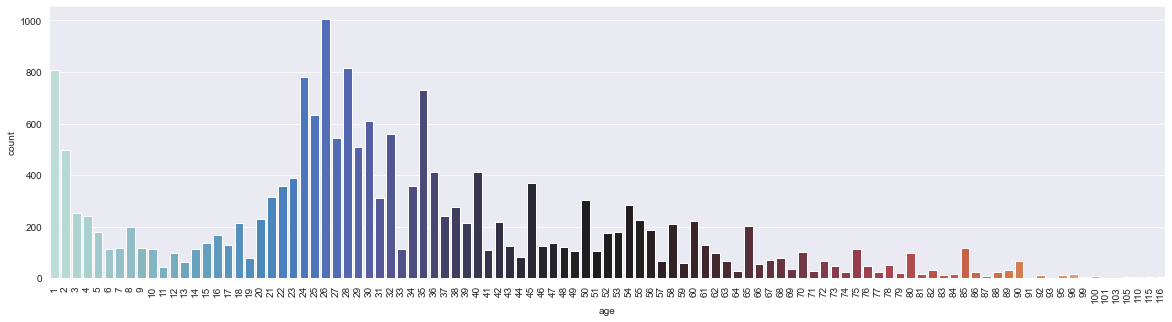

In [130]:
# Check age distribution after some deleting data
import seaborn as sns
plt.figure(figsize=(20,5))
ax = sns.countplot(df['age'], palette='icefire')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

c:\users\vio_g\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ethnicity', ylabel='count'>

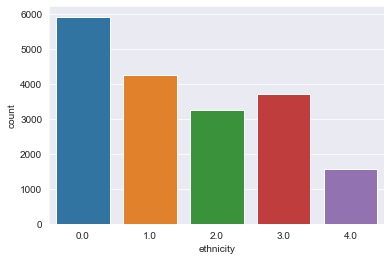

In [131]:
# Check ethnicity distribution after deleting some data
sns.countplot(df['ethnicity'])

# Load Pictures

In [132]:
# WARNING: This might take long
from tqdm import tqdm
from pathlib import Path
images = []

for idx, image in enumerate(tqdm(df['filename'][0:10])):
  path = path_to_pictures + image
  try: 
    img = Image.open(path).convert('RGB') # I use that to make sure all the pictures are RGB
    images.append(img)
    #img = np.array(img)
  except FileNotFoundError as e:
    df = df.drop(idx)
    print(e)
  

100%|██████████| 10/10 [00:00<00:00, 144.51it/s]


In [133]:
df.shape

(18679, 4)

In [134]:
print(images[0])

<PIL.Image.Image image mode=RGB size=1002x1333 at 0x1419FBD1E80>


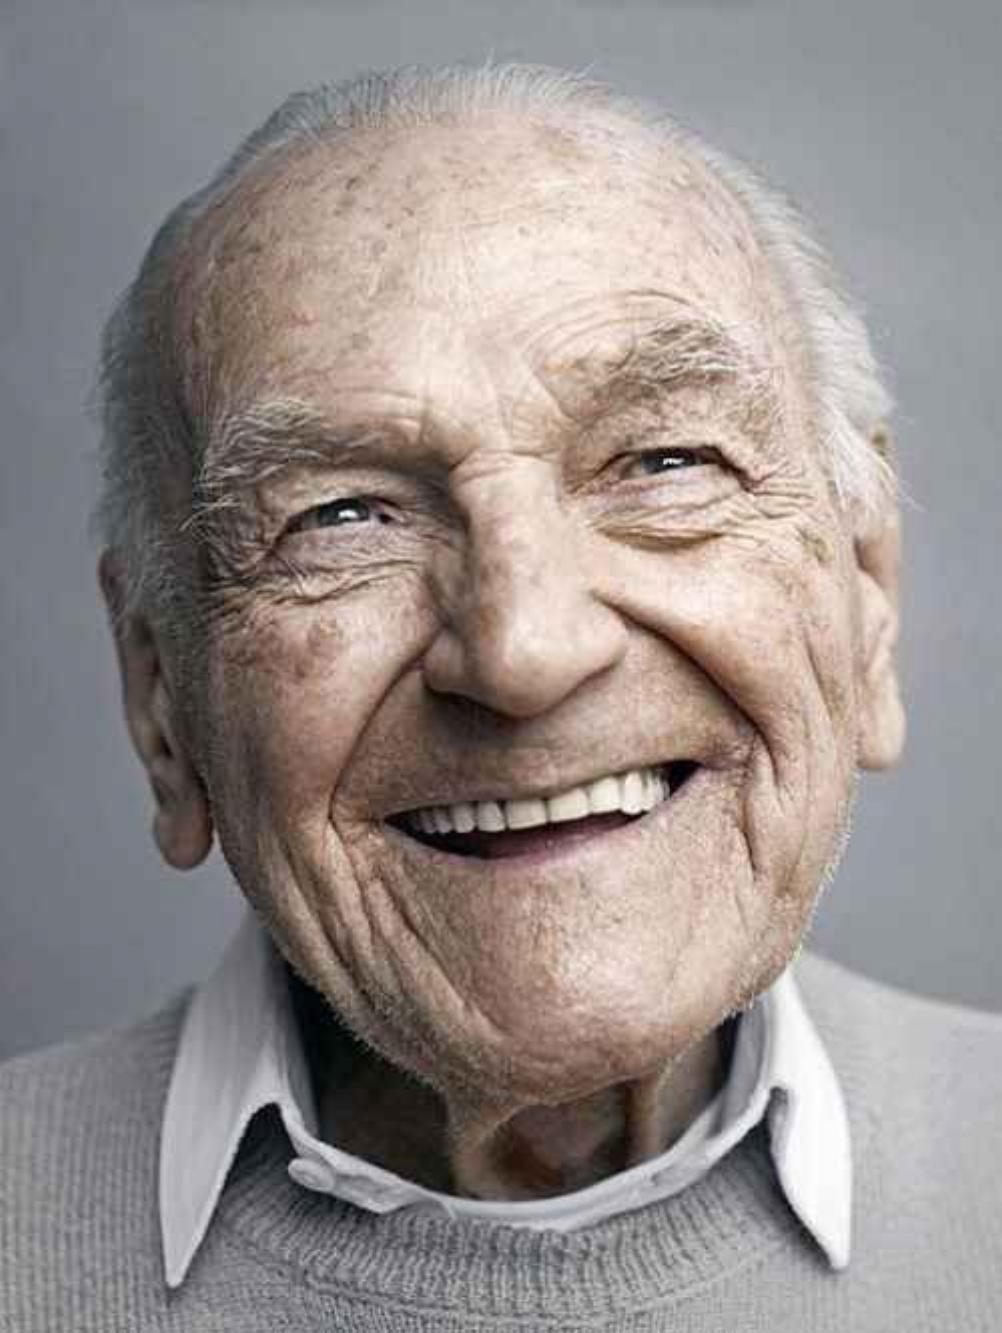

In [135]:
images[0]

# Resize Pictures



### Investigate optimal picture size

In [136]:
# Investigate size of the first 5 pictures:
pixels_in_x_axis = []
pixels_in_y_axis = []

for idx, img in enumerate(images):
  img_array = np.array(img)
  pixels_in_x_axis.append(img_array.shape[0])
  pixels_in_y_axis.append(img_array.shape[1])
  if idx < 5: 
    print(f"Image {idx} has shape {img_array.shape}")

Image 0 has shape (1333, 1002, 3)
Image 1 has shape (470, 450, 3)
Image 2 has shape (1333, 1002, 3)
Image 3 has shape (1039, 786, 3)
Image 4 has shape (551, 368, 3)


In [137]:
# Get average pixel size for axes x and y. 
pixels_in_x_axis = pd.Series(pixels_in_x_axis)
pixels_in_y_axis = pd.Series(pixels_in_y_axis)

print(f"Mean size for pictures is ({pixels_in_x_axis.mean()} , {pixels_in_y_axis.mean()})")
print(f"Smaller size for x is {pixels_in_x_axis.min()} pixel and for y {pixels_in_y_axis.min()} pixels.")

Mean size for pictures is (915.6 , 688.2)
Smaller size for x is 441 pixel and for y 332 pixels.


### Set image size

In [138]:
img_size = (128, 128)

### Resize images

https://pytorch.org/vision/main/generated/torchvision.transforms.Resize.html

In [139]:
# Load the images and resize them using Resize()
resizer = T.Resize(size=img_size)
path_to_small_pic = '../pics/small_pics/'
for idx, imageName in enumerate(tqdm(df['filename'])):
  path = path_to_pictures + imageName
  image_name = path_to_small_pic + imageName
  if os.path.exists(image_name):
    continue
  try:
    image = Image.open(path).convert('RGB') # I use that to make sure all the pictures are RGB
    resized_img =  resizer(image)
    resized_img.save(image_name)
    image.close()
  except (FileNotFoundError, ValueError) as e:
    df = df.drop(idx)
    print(e)

100%|██████████| 18679/18679 [00:00<00:00, 33883.55it/s]

unknown file extension: 


# Upload tar file

In [140]:
df.shape

(18678, 4)

In [141]:
# Save all pictures in a .tar file and upload it to GoogleDrive
import tarfile
path = '../pics/small_pictures.tar'
tar = tarfile.open(path, "w")

from tqdm import tqdm
for idx, name in  enumerate(tqdm(df['filename'])):
  path = path_to_small_pic + name
  try: 
    tar.add(path, arcname=name)
  except:
    print(f"file {name} not found")
    df = df.drop(idx)
tar.close()

 83%|████████▎ | 15547/18678 [00:03<00:00, 4061.43it/s]

file 53_1__ not found


100%|██████████| 18678/18678 [00:04<00:00, 3922.78it/s]


In [142]:
df.shape

(18677, 4)

In [143]:
# Upload reduced dataset
df.to_csv('../datasets/dataset_faces_resized.csv', index=False)